In [1]:
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

mkdir: cannot create directory ‘build’: File exists
-- The C compiler identification is GNU 9.3.0
-- The CXX compiler identification is GNU 9.3.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found PythonInterp: /home/marcelo/.virtualenvs/metnum-tp2/bin/python (found version "3.7.7") 
-- Found PythonLibs: /usr/lib64/libpython3.7m.so
-- pybind11 v2.2.4
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- LTO enabled
CMAKE_INSTALL_PREFIX=/home/marcelo/synchronized/Facultad/metnum/MetNum-1C2020/tp2
-- Configurin

In [2]:
# Verifico la correcta instalación. Si no falla el import está OK
!pwd
!python --version
import metnum


/home/marcelo/synchronized/Facultad/metnum/MetNum-1C2020/tp2/notebooks
Python 3.7.7


In [3]:
%load_ext autoreload
%autoreload 2
import pandas as pd
pd.options.display.max_rows = None

## Carga de archivos

In [4]:
def get_training_data(percentage, percentage_test):
    df = pd.read_csv("../data/train.csv")

    offset      = (df.shape[0]*percentage)//100
    offset_test = (df.shape[0]*percentage_test)//100
        # primeros offset para entrenar
    df_train    = df[:offset]
        # ultimos offset_test para testear
    df_test     = df[df.shape[0]-offset_test:]


    y_train = df_train['label']
    X_train = df_train.drop(columns=['label'])

    y_test  = df_test['label']
    X_test  = df_test.drop(columns=['label'])
    
    return {'X_train': X_train, 'y_train': y_train, 'X_test': X_test, 'y_test': y_test}


In [5]:
# 50% del training set y el ultimo 10% para testear
data_50 = get_training_data(50, 10)

## Experimentos utilizando predict

In [8]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from timeit import default_timer as timer
from sklearn.metrics import accuracy_score

In [7]:
def timed_execution(fun):
    start = timer()
    res = fun()
    end = timer()
    
    return {'res': res, 'time': end - start }

In [8]:
def pca_translation(data, alpha):
    pca_translator = metnum.PCA(alpha)
    initial_execution = timed_execution(lambda: pca_translator.fit(data['X_train']))
    
    res = {}
    res['X_train'] = pca_translator.transform(data['X_train'])
    res['X_test'] = pca_translator.transform(data['X_test'])
    res['y_train'] = data['y_train']
    res['y_test'] = data['y_test']
    
    return {'res': res, 'preprocessing_time': initial_execution['time']}

In [9]:
def pca_curva_completa_predict(data, pca_start = 2, pca_end = 151, pca_step = 2):
    preprocessing_times = []
    execution_times = []
    accuracy = []
    
    for pca in range(pca_start, pca_end, pca_step):
        data_translated = pca_translation(data, pca)
        res = data_translated['res']
        preprocessing_times.append(data_translated['preprocessing_time'])
        
        clf = metnum.KNNClassifier(10)
        clf.fit(res['X_train'], res['y_train'])

        execution = timed_execution(lambda: clf.predict(res['X_test']))

        execution_times.append(execution['time'])
        accuracy.append(accuracy_score(res['y_test'], execution['res']))
        
    return {'preprocessing_times': preprocessing_times, 'execution_times': execution_times, 'accuracy': accuracy}

In [10]:
%%time
pca_response = pca_curva_completa_predict(data_50)

CPU times: user 1h 23min 52s, sys: 15.1 s, total: 1h 24min 7s
Wall time: 1h 23min 54s


In [ ]:
values = pd.DataFrame({'PCA': pca_response['preprocessing_times'], 'KNN': pca_response['execution_times']})
values.to_csv('../data/pca_measure_times.csv')

values.plot()
plt.title("KNN+PCA (50% training, 10% test, k = 10)")
plt.ylabel("Tiempo de ejecución (s)")
plt.xlabel("Cantidad de componentes principales")
loc, labels = plt.xticks()
_=plt.xticks(ticks=loc, labels=np.linspace(2, loc[-1]*2, len(loc), dtype=int))

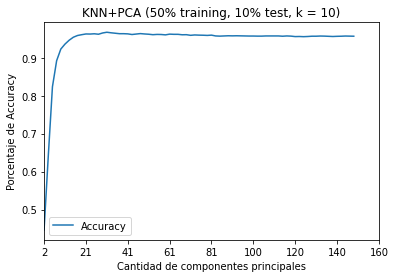

In [12]:
values = pd.DataFrame({'Accuracy': pca_response['accuracy']})
values.to_csv('../data/measure_accuracy.csv')

values.plot()
plt.title("KNN+PCA (50% training, 10% test, k = 10)")
plt.ylabel("Porcentaje de Accuracy")
plt.xlabel("Cantidad de componentes principales")
loc, labels = plt.xticks()
_=plt.xticks(ticks=loc, labels=np.linspace(2, loc[-1]*2, len(loc), dtype=int))

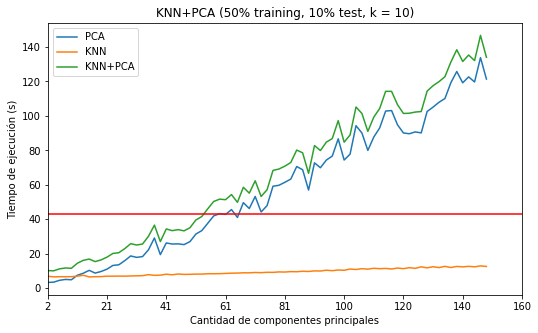

In [49]:
pca_measures = pd.read_csv('../data/pca_measure_times.csv', index_col = 0)
pca_measures['KNN+PCA'] = pca_measures['KNN'] + pca_measures['PCA'] 

pca_measures.plot()
plt.title("KNN+PCA (50% training, 10% test, k = 10)")
plt.ylabel("Tiempo de ejecución (s)")
plt.xlabel("Cantidad de componentes principales")
loc, labels = plt.xticks()
_=plt.xticks(ticks=loc, labels=np.linspace(2, loc[-1]*2, len(loc), dtype=int))
plt.axhline(y=43, color='r', linestyle='-')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(8.5, 5)
fig.savefig('time-knn-pca.png', dpi = 100)

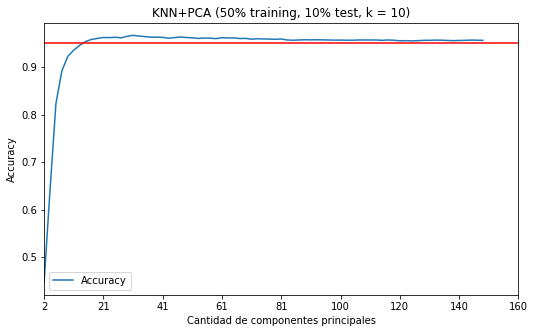

In [51]:
pca_accuracy = pd.read_csv('../data/measure_accuracy.csv', index_col = 0)

pca_accuracy.plot()
plt.title("KNN+PCA (50% training, 10% test, k = 10)")
plt.ylabel("Accuracy")
plt.xlabel("Cantidad de componentes principales")
loc, labels = plt.xticks()
_=plt.xticks(ticks=loc, labels=np.linspace(2, loc[-1]*2, len(loc), dtype=int))
plt.axhline(y=0.952, color='r', linestyle='-')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(8.5, 5)
fig.savefig('accuracy-knn-pca.png', dpi = 100)
